In [43]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModel
import warnings
import warnings
warnings.filterwarnings("ignore")

In [44]:
# Step 1: Preprocessing and Data Augmentation

class ContrastiveTransform:
    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for _ in range(self.n_views)]

class QuickDrawDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            views = self.transform(image)
            return views
        return image

In [45]:
# Data augmentation
color_jitter = transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomApply([color_jitter], p=0.8),
                                      transforms.RandomGrayscale(p=0.2),
                                      transforms.GaussianBlur(kernel_size=23),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

contrastive_transform = ContrastiveTransform(data_transforms)

In [46]:
# Step 2: Contrastive Learning Setup

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=2048, output_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim, bias=False)
        )

    def forward(self, x):
        return self.projection(x)


class DINOv2WithProjection(nn.Module):
    def __init__(self, model_name='facebook/dinov2-base'):
        super().__init__()
        self.dinov2 = AutoModel.from_pretrained(model_name)
        self.projection_head = ProjectionHead()
        self.freeze_dino()  # Freeze the DINOv2 model layers initially

    def freeze_dino(self):
        for param in self.dinov2.parameters():
            param.requires_grad = False  # Freeze DINOv2 weights

    def unfreeze_dino(self):
        for param in self.dinov2.parameters():
            param.requires_grad = True  # Unfreeze DINOv2 weights

    def forward(self, x):
        features = self.dinov2(x).last_hidden_state[:, 0]  # Use CLS token
        return self.projection_head(features)


# NT-Xent loss function
def nt_xent_loss(z1, z2, temperature=0.1):
    batch_size = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)
    z = nn.functional.normalize(z, dim=1)
    
    similarity_matrix = torch.matmul(z, z.T)
    sim_ij = torch.diag(similarity_matrix, batch_size)
    sim_ji = torch.diag(similarity_matrix, -batch_size)
    positives = torch.cat([sim_ij, sim_ji], dim=0)
    
    mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(z1.device)
    negatives = similarity_matrix * mask
    
    logits = torch.cat([positives.unsqueeze(1), negatives.reshape(batch_size * 2, -1)], dim=1)
    logits /= temperature
    
    labels = torch.zeros(2 * batch_size).to(z1.device).long()
    
    loss = nn.CrossEntropyLoss()(logits, labels)
    return loss

In [47]:
# Step 3: Fine-Tuning the DINOv2 Model with LR Scheduler

def train_model(model, train_loader, optimizer, scheduler, device, num_epochs=10):
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for views in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            views = [view.to(device) for view in views]
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                z1, z2 = [model(view) for view in views]
                loss = nt_xent_loss(z1, z2)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        scheduler.step()  # Step the learning rate scheduler
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    return loss_history

In [48]:
# Step 4: Evaluation

def generate_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating embeddings"):
            batch = batch[0].to(device)  # Ensure proper indexing for single view
            embedding = model.dinov2(batch).last_hidden_state[:, 0]  # Use CLS token
            embeddings.append(embedding.cpu().numpy())
    return np.vstack(embeddings)

def plot_similar_images(query_image_idx, dataset, embeddings, n=5):
    query_embedding = embeddings[query_image_idx].reshape(1, -1)
    similarities = np.dot(embeddings, query_embedding.T).squeeze()
    most_similar = np.argsort(similarities)[::-1][:n]

    plt.figure(figsize=(15, 3))
    plt.subplot(1, n+1, 1)
    plt.imshow(dataset[query_image_idx][0].permute(1, 2, 0))
    plt.title("Query Image")
    plt.axis('off')
    
    for i, idx in enumerate(most_similar[1:], start=2):
        plt.subplot(1, n+1, i)
        plt.imshow(dataset[idx][0].permute(1, 2, 0))
        plt.title(f"Sim: {similarities[idx]:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [49]:
# Main execution

Epoch 1/4: 100%|██████████| 56/56 [00:38<00:00,  1.46it/s]


Epoch 1, Loss: 1.8911


Epoch 2/4: 100%|██████████| 56/56 [00:39<00:00,  1.43it/s]


Epoch 2, Loss: 1.7137


Epoch 3/4: 100%|██████████| 56/56 [00:40<00:00,  1.37it/s]


Epoch 3, Loss: 1.6474


Epoch 4/4: 100%|██████████| 56/56 [00:41<00:00,  1.34it/s]


Epoch 4, Loss: 1.5873


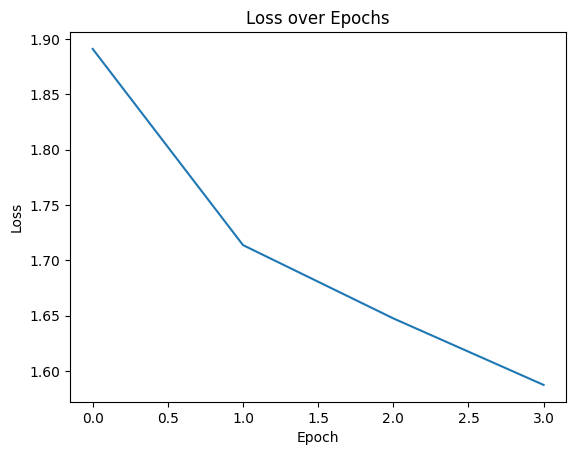

In [50]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and prepare data
root_dir = "/kaggle/input/quick-draw-subset/quick_draw_subset"
image_paths = []

for category in os.listdir(root_dir):
    category_dir = os.path.join(root_dir, category)
    if os.path.isdir(category_dir):
        images = os.listdir(category_dir)
        top_images = images[:5]
        for image in top_images:
            image_path = os.path.join(category_dir, image)
            image_paths.append(image_path)

df = pd.DataFrame(image_paths, columns=["image_path"])

dataset = QuickDrawDataset(df, transform=contrastive_transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

# Initialize model
model = DINOv2WithProjection().to(device)

# Set up optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train the model
loss_history = train_model(model, train_loader, optimizer, scheduler, device, num_epochs=4)

# Plot loss over epochs
plt.plot(loss_history)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Save the final model
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

# uncomment for Inference (Work in Progress...)

# Generate embeddings for evaluation
# eval_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# eval_dataset = QuickDrawDataset(df, transform=eval_transform)
# eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# embeddings = generate_embeddings(model, eval_loader, device)

# # Visualize similar images
# query_image_idx = 0  # Change this to visualize different query images
# plot_similar_images(query_image_idx, eval_dataset, embeddings, n=5)